In [2]:
#import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10,6)
from sklearn import preprocessing
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor

from sklearn.metrics import make_scorer, mean_squared_error


def mean_squared_error_(ground_truth, predictions):
    return mean_squared_error(ground_truth, predictions) ** 0.5
RMSE = make_scorer(mean_squared_error_, greater_is_better=False) 
%matplotlib inline

In [12]:
#load the train
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
test_features = test
train = pd.concat([train, test_features]).reset_index(drop=True)

/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [13]:
train.shape

(2919, 81)

In [14]:
test.shape

(1459, 80)

In [15]:
#overview ofthe train
train.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [16]:
#stats of the predictor variable (saleprice)
train.SalePrice.describe().round(2)

count      1460.0
mean     180921.2
std       79442.5
min       34900.0
25%      129975.0
50%      163000.0
75%      214000.0
max      755000.0
Name: SalePrice, dtype: float64

skew is 1.8828757597682129


/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


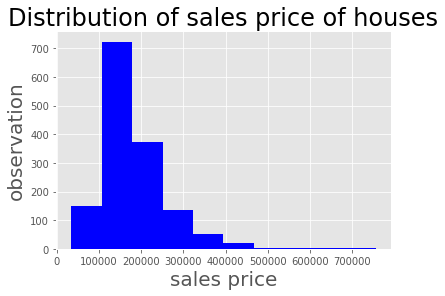

In [17]:
#analysing the distribution of sale price
print('skew is', train.SalePrice.skew())   
plt.hist(train['SalePrice'], color= 'b')

plt.title('Distribution of sales price of houses', fontsize = 24)
plt.ylabel('observation', fontsize = 20)
plt.xlabel('sales price', fontsize = 20)

plt.show()

In [18]:
#log transforming sale price to transform it into gaussian distribution
target = np.log(train.SalePrice)

skew is 0.12133506220520401


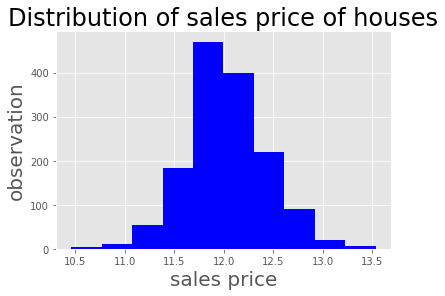

In [19]:
print('skew is', target.skew())
plt.hist(target, color= 'b')

plt.title('Distribution of sales price of houses', fontsize = 24)
plt.ylabel('observation', fontsize = 20)
plt.xlabel('sales price', fontsize = 20)

plt.show()

In [20]:
#seeking only the numeric features from the train
numeric_features = train.select_dtypes(include = [np.number])
numeric_features.dtypes

1stFlrSF           int64
2ndFlrSF           int64
3SsnPorch          int64
BedroomAbvGr       int64
BsmtFinSF1       float64
BsmtFinSF2       float64
BsmtFullBath     float64
BsmtHalfBath     float64
BsmtUnfSF        float64
EnclosedPorch      int64
Fireplaces         int64
FullBath           int64
GarageArea       float64
GarageCars       float64
GarageYrBlt      float64
GrLivArea          int64
HalfBath           int64
Id                 int64
KitchenAbvGr       int64
LotArea            int64
LotFrontage      float64
LowQualFinSF       int64
MSSubClass         int64
MasVnrArea       float64
MiscVal            int64
MoSold             int64
OpenPorchSF        int64
OverallCond        int64
OverallQual        int64
PoolArea           int64
SalePrice        float64
ScreenPorch        int64
TotRmsAbvGrd       int64
TotalBsmtSF      float64
WoodDeckSF         int64
YearBuilt          int64
YearRemodAdd       int64
YrSold             int64
dtype: object

In [21]:
#features with the most correlation with the predictor variable
corr = numeric_features.corr()
print(corr['SalePrice'].sort_values(ascending = False)[:5], '\n')
print(corr['SalePrice'].sort_values(ascending = False)[-5:])

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64 

YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


In [22]:
train.OverallQual.unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2])

In [23]:
#pivot table of Overall Quality & Sale price
quality_pivot = train.pivot_table(index= 'OverallQual', values= 'SalePrice')

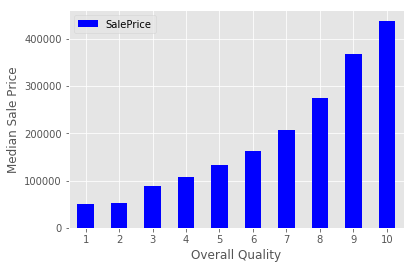

In [24]:
#plotting the pivot table
quality_pivot.plot(kind = 'bar', color = 'blue')

plt.xlabel('Overall Quality')
plt.ylabel('Median Sale Price')
plt.xticks(rotation = 0)
plt.show()

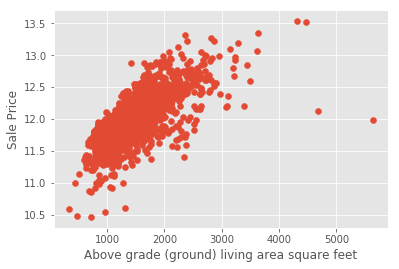

In [25]:
#Analysing the feature - ground living area 
plt.scatter(x = train['GrLivArea'], y = target)

plt.xlabel('Above grade (ground) living area square feet')
plt.ylabel('Sale Price')
plt.show()

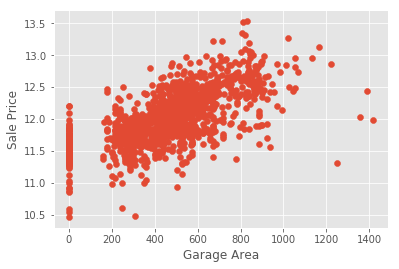

In [26]:
#Analysing the feature - garage area
plt.scatter(x = train['GarageArea'], y = target)

plt.xlabel('Garage Area')
plt.ylabel('Sale Price')
plt.show()

In [27]:
#removing the outliers
train = train[train['GarageArea'] < 1200]

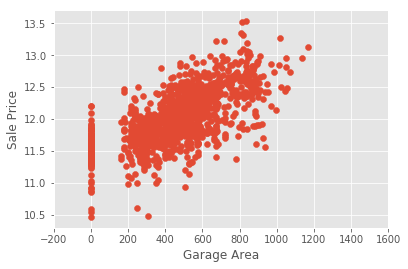

In [28]:
plt.scatter(x = train['GarageArea'], y = np.log(train.SalePrice))

plt.xlim(-200, 1600)
plt.xlabel('Garage Area')
plt.ylabel('Sale Price')
plt.show()

In [29]:
#checking the null values
nulls = pd.DataFrame(train.isnull().sum().sort_values(ascending = False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
nulls[:5]

,Null Count
Feature,
PoolQC,2899
MiscFeature,2804
Alley,2711
Fence,2340
SalePrice,1453


In [30]:
print('Unique values are:', train.MiscFeature.unique())

Unique values are: [nan 'Shed' 'Gar2' 'Othr' 'TenC']


In [31]:
#analysing the categorical train
categoricals = train.select_dtypes(exclude= [np.number])
categoricals.describe()

,Alley,BldgType,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtQual,CentralAir,Condition1,Condition2,...,MiscFeature,Neighborhood,PavedDrive,PoolQC,RoofMatl,RoofStyle,SaleCondition,SaleType,Street,Utilities
count,197,2908,2826,2826,2829,2828,2827,2908,2908,2908,...,104,2908,2908,9,2908,2908,2908,2907,2908,2906
unique,2,5,4,4,6,6,4,2,9,8,...,4,25,3,3,7,6,6,9,2,2
top,Grvl,1Fam,TA,No,Unf,Unf,TA,Y,Norm,Norm,...,Shed,NAmes,Y,Ex,CompShg,Gable,Normal,WD,Pave,AllPub
freq,119,2415,2596,1898,847,2482,1279,2712,2502,2879,...,94,442,2631,4,2867,2305,2397,2518,2897,2905


In [32]:
print ("Original: \n") 
print (train.Street.value_counts(), "\n")

Original: 

Pave    2897
Grvl      11
Name: Street, dtype: int64 



In [33]:
#One-hot encoding to convert the categorical train into integer train
train['enc_street'] = pd.get_dummies(train.Street, drop_first= True)
test['enc_street'] = pd.get_dummies(test.Street, drop_first= True)

In [34]:
print('Encoded: \n')
print(train.enc_street.value_counts())

Encoded: 

1    2897
0      11
Name: enc_street, dtype: int64


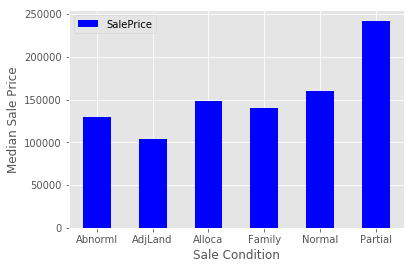

In [35]:
#Analysing the feature - Sale Condition
condition_pivot = train.pivot_table(index= 'SaleCondition', values= 'SalePrice', aggfunc= np.median)

condition_pivot.plot(kind= 'bar', color = 'blue')
plt.xlabel('Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation = 0)
plt.show()

In [36]:
def encode(x): 
    if x == 'Partial':
        return 1
    else:
        return 0        

In [37]:

#Treating partial as one class and other all sale condition as other
train['enc_condition'] = train.SaleCondition.apply(encode)
test['enc_condition'] = test.SaleCondition.apply(encode)

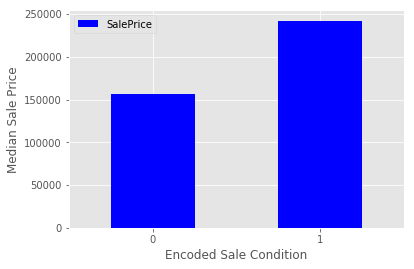

In [38]:
condition_pivot = train.pivot_table(index= 'enc_condition', values= 'SalePrice', aggfunc= np.median)

condition_pivot.plot(kind= 'bar', color = 'blue')
plt.xlabel('Encoded Sale Condition')
plt.ylabel('Median Sale Price')
plt.xticks(rotation = 0)
plt.show()

In [39]:
train["PoolQC"] = train["PoolQC"].fillna("None")
train["MiscFeature"] = train["MiscFeature"].fillna("None")
train["Alley"] = train["Alley"].fillna("None")
train["Fence"] = train["Fence"].fillna("None")
train["FireplaceQu"] = train["FireplaceQu"].fillna("None")
# Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    train[col] = train[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    train[col] = train[col].fillna(0)
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    train[col] = train[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    train[col] = train[col].fillna('None')
train["MasVnrType"] = train["MasVnrType"].fillna("None")
train["MasVnrArea"] = train["MasVnrArea"].fillna(0)
train['MSZoning'] = train['MSZoning'].fillna(train['MSZoning'].mode()[0])
train = train.drop(['Utilities'], axis=1)
train["Functional"] = train["Functional"].fillna("Typ")
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])
train['KitchenQual'] = train['KitchenQual'].fillna(train['KitchenQual'].mode()[0])
train['Exterior1st'] = train['Exterior1st'].fillna(train['Exterior1st'].mode()[0])
train['Exterior2nd'] = train['Exterior2nd'].fillna(train['Exterior2nd'].mode()[0])
train['SaleType'] = train['SaleType'].fillna(train['SaleType'].mode()[0])
train['MSSubClass'] = train['MSSubClass'].fillna("None")


In [40]:
# Group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))


In [41]:
train.drop(train[(train.LotShape == 'IR2') & (train.SalePrice > 300000)].index, inplace=True)
train.drop(train[(train.LandContour == 'Bnk') & (train.SalePrice > 300000)].index, inplace=True)
train.drop(train[(train.PavedDrive == 'P') & (train.SalePrice > 200000)].index, inplace=True)
train.drop(train[(train.MSZoning == 'RL') & (train.SalePrice > 500000)].index, inplace=True)
train.drop(train[(train.KitchenQual == 'TA') & (train.SalePrice > 300000)].index, inplace=True)
train.drop(train[(train.MSZoning == 'RM') & (train.SalePrice > 350000)].index, inplace=True)
train.drop(train[(train.LotConfig == 'Corner') & (train.SalePrice > 410000)].index, inplace=True)
train.drop(train[(train.Functional == 'Min2') & (train.SalePrice > 300000)].index, inplace=True)
train.drop(train[(train.HouseStyle == '1.5Fin') & (train.SalePrice > 400000)].index, inplace=True)
train.drop(train[(train.LandContour == 'Low') & (train.SalePrice > 350000)].index, inplace=True)

In [42]:
#Handling the missing values by interpolation
data = train.select_dtypes(include= [np.number]).interpolate().dropna()

In [43]:
#Verifying missing values
sum(data.isnull().sum() != 0)


0

In [44]:
#log transforming the target variable to improve the linearity of the regression
y = np.log(data.SalePrice)
#dropping the target variable and the index from the training set
X = data.drop(['SalePrice', 'Id'], axis = 1)

In [45]:
#splitting the train into training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = .33)

In [46]:
#Linear regression model
from sklearn import linear_model
lr = linear_model.LinearRegression()

In [47]:
#fitting linear regression on the train
model = lr.fit(X_train, y_train)

In [48]:
#R square value
print('R square is: {}'.format(model.score(X_test, y_test)))

R square is: 0.41195492054741223


In [49]:
#predicting on the test set
predictions = model.predict(X_test)

In [50]:
#evaluating the model on mean square error
from sklearn.metrics import mean_squared_error, accuracy_score
print('RMSE is {}'.format(mean_squared_error(y_test, predictions)))

RMSE is 0.0450318800968649


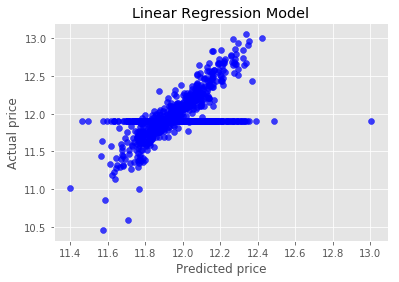

In [51]:
actual_values = y_test
plt.scatter(predictions, actual_values, alpha= 0.75, color = 'b')

plt.xlabel('Predicted price')
plt.ylabel('Actual price')
plt.title('Linear Regression Model')
plt.show()

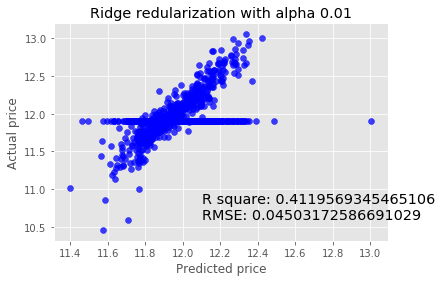

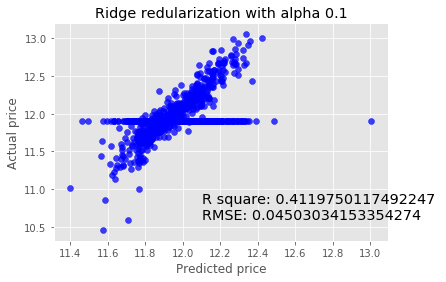

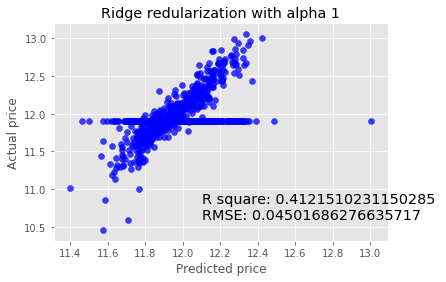

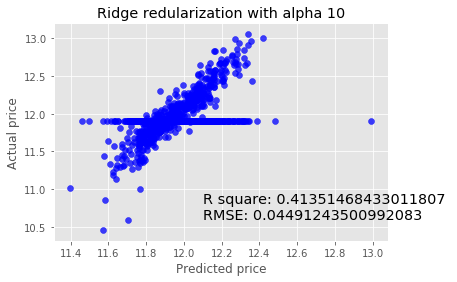

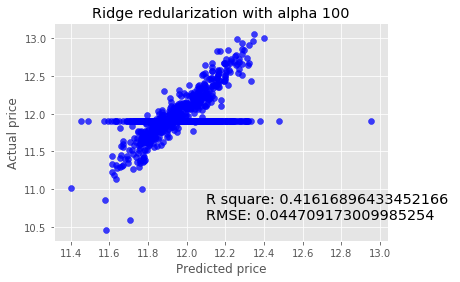

In [52]:
#Linear regression with L2 regularization
for i in range(-2, 3):
    alpha = 10**i
    rm = linear_model.Ridge(alpha = alpha)
    ridge_model = rm.fit(X_train, y_train)
    preds_ridge = ridge_model.predict(X_test)
    
    plt.scatter(preds_ridge, y_test, alpha= 0.75, c= 'b')
    plt.xlabel('Predicted price')
    plt.ylabel('Actual price')
    plt.title('Ridge redularization with alpha {}'.format(alpha))
    overlay = 'R square: {} \nRMSE: {}'.format(ridge_model.score(X_test, y_test), mean_squared_error(y_test, preds_ridge))
    plt.annotate(s = overlay, xy = (12.1, 10.6), size = 'x-large')
    plt.show()

In [53]:
#Gradient boosting regressor model
from sklearn.ensemble import GradientBoostingRegressor

In [54]:
def model_gradient_boosting_tree(Xtrain,Xtest,ytrain):
    
    X_train = Xtrain
    y_train = ytrain 
    gbr = GradientBoostingRegressor(random_state=0)
    param_grid = {
        'n_estimators': [500],
        'max_features': [10,15],
        'max_depth': [6,8,10],
        'learning_rate': [0.05,0.1,0.15],
        'subsample': [0.8]
    }
    model = GridSearchCV(estimator=gbr, param_grid=param_grid, n_jobs=1, cv=10)
    model.fit(X_train, y_train)
    y_pred = model.predict(Xtest)
    return y_pred


y_pred_GBT=model_gradient_boosting_tree(X_train,X_test,y_train)

est_test = mean_squared_error(y_test, y_pred_GBT)
print('Mean square error on the Test set is: {}'.format(est_test))

Mean square error on the Test set is: 0.04697309369226912


In [55]:
def model_random_forecast(Xtrain,Xtest,ytrain):
    
    X_train = Xtrain
    y_train = ytrain
    rfr = RandomForestRegressor(n_jobs=1, random_state=0)
    param_grid = {}#'n_estimators': [500], 'max_features': [10,15,20,25], 'max_depth':[3,5,7,9,11]}
    model = GridSearchCV(estimator=rfr, param_grid=param_grid, n_jobs=1, cv=10,scoring=RMSE)
    model.fit(X_train, y_train)

    y_pred = model.predict(Xtest)
    return y_pred

y_pred_RF=model_random_forecast(X_train,X_test,y_train)

est_test = mean_squared_error(y_test, y_pred_RF)
print('Mean square error on the Test set is: {}'.format(est_test))

/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/AvyaTiK/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/AvyaTiK/anaconda3/lib/python3

Mean square error on the Test set is: 0.04942548999582724


In [56]:
from sklearn.linear_model import RidgeCV

def ridgeRegr():
        # Fitting the model and predicting using Ridge Regression
        ridgeregr = RidgeCV(alphas=[0.1,0.001,0.0001,1,2,3,4,5,6,7,8,9,10,11,12]).fit(X_train, y_train)
        y_ridge = ridgeregr.predict(X_test)

        
        return y_ridge
y_pred_RR=ridgeRegr()


est_test = mean_squared_error(y_test, y_pred_RR)
print('Mean square error on the Test set is: {}'.format(est_test))


Mean square error on the Test set is: 0.044895090878908854


In [57]:
regr = xgb.XGBRegressor(colsample_bytree=0.4,
                gamma=0.045,
                learning_rate=0.07,
                max_depth=20,
                min_child_weight=1.5,
                n_estimators=300,
                reg_alpha=0.65,
                reg_lambda=0.45,
                subsample=0.95)
regr.fit(X_train, y_train)
y_pred_xgb = regr.predict(X_test)

est_test = mean_squared_error(y_test, y_pred_xgb)
print('Mean square error on the Test set is: {}'.format(est_test))

NameError: name 'xgb' is not defined

In [ ]:
est = GradientBoostingRegressor(n_estimators= 500, max_depth= 6, learning_rate= .05 ,max_features=10,subsample=.8)
est.fit(X_train, y_train)

In [ ]:
y_train_predict = est.predict(X_train)

In [ ]:
y_test_predict = est.predict(X_test)

In [ ]:
est_train = mean_squared_error(y_train, y_train_predict)
print('Mean square error on the Train set is: {}'.format(est_train))

In [ ]:
est_test = mean_squared_error(y_test, y)
print('Mean square error on the Test set is: {}'.format(est_test))

In [ ]:
submission = pd.DataFrame()
submission['Id'] = test.Id
feats = test.select_dtypes(
        include=[np.number]).drop(['Id'], axis=1).interpolate()
predictions=mo.predict(feats)
final_predictions = np.exp(predictions)
submission['SalePrice'] = final_predictions
submission.to_csv('submission10_2.csv', index=False)

In [64]:
print('train :',train.shape,'df : ',train.shape)

train : (1431, 82) df :  (1431, 82)
